In [107]:
# this is a first pass analysis of gamma cross sections data 

from os import listdir
from os.path import isfile, join
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.integrate import quad as int_quad

In [43]:
# import data and investigate contents 

thick_0_5 = pd.read_csv('first_pass_data/2020_10_8_18_45_57_Gammas_0.5mm.csv')
print(thick_0_5.columns)
thick_0_5 = thick_0_5.loc[480:600]
thick_0_5

Index(['Channel', 'Counts'], dtype='object')


,Channel,Counts
480,480,321
481,481,312
482,482,305
483,483,293
484,484,318
...,...,...
596,596,156
597,597,158
598,598,151
599,599,175


In [46]:
thick_0_0 = pd.read_csv('first_pass_data/2020_10_8_18_29_31_Gammas_0_0mm.csv')
thick_0_0 = thick_0_0.loc[480:600]
thick_0_0

,Channel,Counts
480,480,296
481,481,263
482,482,274
483,483,278
484,484,260
...,...,...
596,596,161
597,597,162
598,598,166
599,599,191


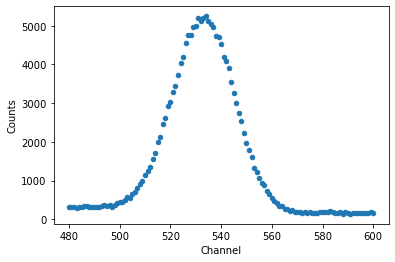

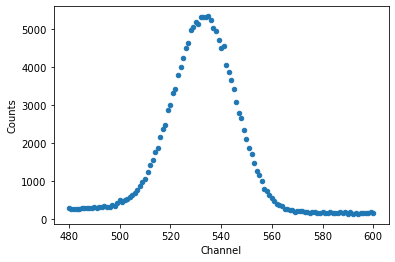

In [47]:
thick_0_5.plot(x = 'Channel', y='Counts', kind='scatter')
# expected peak around 520 ish 

thick_0_0.plot(x = 'Channel', y='Counts', kind='scatter')

[ 5.09665209e+03  5.33158553e+02  1.20058610e+01 -1.53663937e+00
  1.05453548e+03]


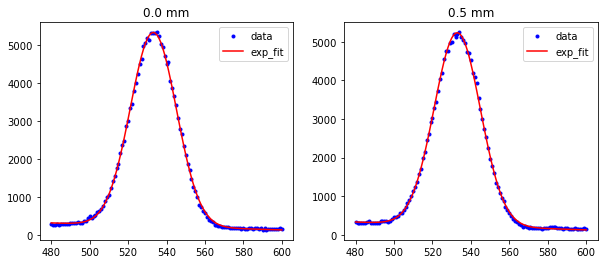

In [95]:
# we fit a gaussian to both and compute the integral under the curve

def fit_model(x, A, mu, sigma, m, b):
    return A*np.exp(-0.5*((x - mu)/sigma)**2) + m*x + b

chan = thick_0_0['Channel'].to_numpy()

pars_0_0, cov_0_0 = curve_fit(f=fit_model, xdata=chan, ydata=thick_0_0['Counts'], p0=[5000, 530, 30, 0.5, 0.5])
pars_0_5, cov_0_5 = curve_fit(f=fit_model, xdata=chan, ydata=thick_0_5['Counts'], p0=[5000, 530, 30, 0.5, 0.5])

fited_0_0 = fit_model(chan, pars_0_0[0], pars_0_0[1], pars_0_0[2], pars_0_0[3], pars_0_0[4])
fited_0_5 = fit_model(chan, pars_0_5[0], pars_0_5[1], pars_0_5[2], pars_0_5[3], pars_0_5[4])

# plot fit and data 
fig = plt.figure(figsize = (10,4))
ax =fig.add_subplot(1,2,1)
ay =fig.add_subplot(1,2,2)

ax.plot(chan, thick_0_0['Counts'].to_numpy(), 'b.', label='data')
ax.plot(chan, fit_model(chan, pars_0_0[0], pars_0_0[1], pars_0_0[2], pars_0_0[3], pars_0_0[4]), 'r-', label='exp_fit')
ax.legend()
ax.set_title('0.0 mm')

ay.plot(chan, thick_0_5['Counts'].to_numpy(), 'b.', label='data')
ay.plot(chan, fit_model(chan, pars_0_5[0], pars_0_5[1], pars_0_5[2], pars_0_5[3], pars_0_5[4]), 'r-', label='exp_fit')
ay.legend()
ay.set_title('0.5 mm')

print(pars_0_0)

In [101]:
# integrate fits to find num photons reaching detector at 0 and 0.5 mm thickness 

fited_0_0 = lambda x : fit_model(x, pars_0_0[0], pars_0_0[1], pars_0_0[2], pars_0_0[3], pars_0_0[4])
fited_0_5 = lambda x : fit_model(x, pars_0_5[0], pars_0_5[1], pars_0_5[2], pars_0_5[3], pars_0_5[4])
N_0_0 = int_quad(fited_0_0, 480, 600)
N_0_5 = int_quad(fited_0_5, 480, 600)

print(N_0_5[0] / N_0_0[0])

0.9869501397394377


In [124]:
# duplicate above analysis for all thickness values and fit to exp(-lambda t)

class Analysis:
    # thickness expected in mm
    # expect Channel and Counts fields in data
    def __init__(self, filename, thickness):
        # doing cut arbitrarily by eye here 
        # come up with better estimate for this
        self.low = 480
        self.high = 600
        self.data = pd.read_csv(filename).loc[self.low:self.high]
        self.chan = self.data['Channel'].to_numpy()

    def fit_model(self, x, A, mu, sigma, m, b):
        # model to be fitted
        return A*np.exp(-0.5*((x - mu)/sigma)**2) + m*x + b
    
    def fit_params(self):
        # return fit params
        self.pars, self.cov = curve_fit(f=self.fit_model, xdata=self.chan, ydata=self.data['Counts'], p0=[5000, 530, 30, 0.5, 0.5])
        return self.pars, self.cov
    
    def fit(self):
        # returns fitted function evaluated on self.chan
        self.pars, self.cov = self.fit_params()
        self.fited = self.fit_model(self.chan, self.pars[0], self.pars[1], self.pars[2], self.pars[3], self.pars[4])
        return self.fited
    
    def compute_gamma_num(self):
        self.pars, self.cov = self.fit_params()
        self._fited = lambda x : self.fit_model(x, self.pars[0], self.pars[1], self.pars[2], self.pars[3], self.pars[4])
        self.N = int_quad(self._fited, self.low, self.high)
        return self.N

0.9869501397394377
[0.8, 3.2, 1.6, 0.4, 0.1, 0.0, 0.2, 0.05]
[0.8883912329178993, 0.6277198849319948, 0.7869213169021088, 0.9376899941198948, 0.9801830105726336, 1.0, 0.9651082040478435, 0.9869501397394377]


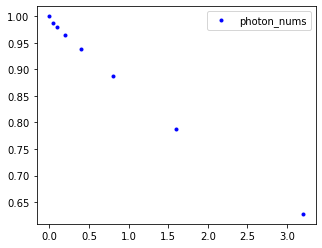

In [160]:
path = 'first_pass_data/2020_10_8/'
files = [f for f in listdir(path) if isfile(join(path, f))]

photon_nums = {} # thicknes : (nums, error)
for file in files:
    thickness = file[:-4] # some slice
    analysis = Analysis(path+file, thickness)
    photon_nums[thickness] = analysis.compute_gamma_num()

#print(photon_nums)
print(photon_nums['0.5mm'][0] / photon_nums['0.0mm'][0])

thickness = [float(s[:-2]) / 10 for s in photon_nums.keys()]
nums = [(s[0] / photon_nums['0.0mm'][0]) for s in photon_nums.values()] 

print(thickness)
print(nums)

fig, ax = plt.subplots(figsize = (5,4))

ax.plot(thickness, nums, 'b.', label='photon_nums')
ax.legend()

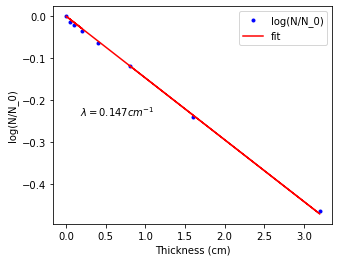

In [184]:
# fit exp(- lambda*w) to above data

def cs_fit_model(x, lmda):
    x = np.array(x)
    return np.exp(-1*lmda*x)

fitted_cross_section_params = curve_fit(f=cs_fit_model, xdata=thickness, ydata=nums, p0=[5])

# plot fit and data 
fig, ax = plt.subplots(figsize = (5,4))
fited_nums_log = np.log(cs_fit_model(thickness, fitted_cross_section_params[0][0]))

ax.set_xlabel('Thickness (cm)')
ax.set_ylabel('log(N/N_0)')

ax.plot(thickness, np.log(nums), 'b.', label='log(N/N_0)')
ax.plot(thickness, fited_nums_log, 'r-', label='fit')
plt.figtext(0.2, 0.5, "$\lambda = $" + str(fitted_cross_section_params[0][0])[:5] + '$cm^{-1}$')
ax.legend()